In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = True, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [4]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_new_category_infos(date_key, except_is_ppp = True, except_is_track = True, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    if except_is_ppp:
        categoryRankList = [item for item in categoryRankList if not item.isPpp]
    if except_is_track:
        categoryRankList = [item for item in categoryRankList if not item.isTrack]
    

    sorted_block_rank_list = sorted(categoryRankList, key=lambda x: (-x.num, -x.numChange))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item.categoryCode
        num = item.num

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [5]:


hd_pct = 0.001

strategy_name = '中位孕线低吸'
days = 3
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 3,
        "top_cx": 1,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": True
      },
      
        ]

filter_count = 0
filter_amount = 10000000
gap = 0
rank_filter =  True
rerank_category = True
sell_use_open = True
except_is_ppp = True
except_is_track = True

In [6]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        print(f"{stock_code}-{datekey}")
        real_amount = 0

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        print(f"{stock_code}-{datekey}")
        last_price_real = -1

    return last_price_real

In [7]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                # result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                result = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\new_strategy_eval\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [8]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [9]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503', '202504', '202505']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,994,2024-09-04,低吸,中位孕线低吸,600114.XSHG,东睦股份,1,"000036.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885520.DDBK,885785.DDBK,885537.DDBK,885806.DDB...",980365.ZHBK,...,中位孕线低吸,-60.890000,28.61,65,-61.660000,7.50,45,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:44:21
1,1087,2024-09-06,低吸,中位孕线低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",...,中位孕线低吸,26.500000,120.66,13,-7.850000,53.47,31,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:29
2,1088,2024-09-06,低吸,中位孕线低吸,600552.XSHG,凯盛科技,2,"000036.BKDL,000035.BKDL,000006.BKDL,000037.BKD...","885520.DDBK,886021.DDBK,885710.DDBK,885806.DDB...",980357.ZHBK,...,中位孕线低吸,26.500000,120.66,13,-7.850000,53.47,31,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:29
3,2183,2024-09-20,低吸,中位孕线低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000023.BKDL,000015.BKD...","886021.DDBK,885694.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",...,中位孕线低吸,-11.770000,1.13,119,-48.450000,0.29,131,"{""9B0003"": {""realShortLineScore"": -65.29, ""rea...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-03-26 06:13:35
4,2465,2024-09-26,低吸,中位孕线低吸,600619.XSHG,海立股份,1,"000038.BKDL,000023.BKDL,000035.BKDL,000010.BKD...","885338.DDBK,886021.DDBK,885999.DDBK,885472.DDB...",,...,中位孕线低吸,35.990000,-21.26,66,3.050000,6.27,82,"{""9B0003"": {""realShortLineScore"": -35.11, ""rea...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-26 06:20:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,6827,2025-05-29,低吸,中位孕线低吸,002431.XSHE,棕榈股份,1,"000012.BKDL,000008.BKDL,000038.BKDL,000024.BKD...","885692.DDBK,886021.DDBK,885750.DDBK,883437.DDB...",,...,中位孕线低吸,144.679993,8.59,24,131.889999,-0.05,2,"{""9A0001"": {""realShortLineScore"": 31.909999847...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-05-30 07:30:48
204,6828,2025-05-29,低吸,中位孕线低吸,002174.XSHE,游族网络,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886100.DDBK,885840.DDBK,885867.DDBK,885890.DDB...",,...,中位孕线低吸,144.679993,8.59,24,131.889999,-0.05,2,"{""9A0001"": {""realShortLineScore"": 31.909999847...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-05-30 07:30:48
205,7325,2025-05-30,低吸,中位孕线低吸,002437.XSHE,誉衡药业,1,"000038.BKDL,000023.BKDL,000015.BKDL,000004.BKD...","885767.DDBK,885867.DDBK,883437.DDBK,886081.DDB...",,...,中位孕线低吸,170.550003,-6.18,10,147.009995,1.76,2,"{""9A0001"": {""realShortLineScore"": 27.260000228...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-06-03 07:30:48
206,7326,2025-05-30,低吸,中位孕线低吸,603577.XSHG,汇金通,2,"000035.BKDL,000023.BKDL","885571.DDBK,885425.DDBK,886079.DDBK,886097.DDB...",,...,中位孕线低吸,170.550003,-6.18,10,147.009995,1.76,2,"{""9A0001"": {""realShortLineScore"": 27.260000228...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-06-03 07:30:48


In [10]:
# combined_df = combined_df.head(2)

In [11]:
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,994,2024-09-04,低吸,中位孕线低吸,600114.XSHG,东睦股份,1,"000036.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885520.DDBK,885785.DDBK,885537.DDBK,885806.DDB...",980365.ZHBK,...,中位孕线低吸,-60.890000,28.61,65,-61.660000,7.50,45,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:44:21
1,1087,2024-09-06,低吸,中位孕线低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",...,中位孕线低吸,26.500000,120.66,13,-7.850000,53.47,31,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:29
2,1088,2024-09-06,低吸,中位孕线低吸,600552.XSHG,凯盛科技,2,"000036.BKDL,000035.BKDL,000006.BKDL,000037.BKD...","885520.DDBK,886021.DDBK,885710.DDBK,885806.DDB...",980357.ZHBK,...,中位孕线低吸,26.500000,120.66,13,-7.850000,53.47,31,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:29
3,2183,2024-09-20,低吸,中位孕线低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000023.BKDL,000015.BKD...","886021.DDBK,885694.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",...,中位孕线低吸,-11.770000,1.13,119,-48.450000,0.29,131,"{""9B0003"": {""realShortLineScore"": -65.29, ""rea...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-03-26 06:13:35
4,2465,2024-09-26,低吸,中位孕线低吸,600619.XSHG,海立股份,1,"000038.BKDL,000023.BKDL,000035.BKDL,000010.BKD...","885338.DDBK,886021.DDBK,885999.DDBK,885472.DDB...",,...,中位孕线低吸,35.990000,-21.26,66,3.050000,6.27,82,"{""9B0003"": {""realShortLineScore"": -35.11, ""rea...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-26 06:20:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,6827,2025-05-29,低吸,中位孕线低吸,002431.XSHE,棕榈股份,1,"000012.BKDL,000008.BKDL,000038.BKDL,000024.BKD...","885692.DDBK,886021.DDBK,885750.DDBK,883437.DDB...",,...,中位孕线低吸,144.679993,8.59,24,131.889999,-0.05,2,"{""9A0001"": {""realShortLineScore"": 31.909999847...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-05-30 07:30:48
204,6828,2025-05-29,低吸,中位孕线低吸,002174.XSHE,游族网络,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886100.DDBK,885840.DDBK,885867.DDBK,885890.DDB...",,...,中位孕线低吸,144.679993,8.59,24,131.889999,-0.05,2,"{""9A0001"": {""realShortLineScore"": 31.909999847...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-05-30 07:30:48
205,7325,2025-05-30,低吸,中位孕线低吸,002437.XSHE,誉衡药业,1,"000038.BKDL,000023.BKDL,000015.BKDL,000004.BKD...","885767.DDBK,885867.DDBK,883437.DDBK,886081.DDB...",,...,中位孕线低吸,170.550003,-6.18,10,147.009995,1.76,2,"{""9A0001"": {""realShortLineScore"": 27.260000228...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-06-03 07:30:48
206,7326,2025-05-30,低吸,中位孕线低吸,603577.XSHG,汇金通,2,"000035.BKDL,000023.BKDL","885571.DDBK,885425.DDBK,886079.DDBK,886097.DDB...",,...,中位孕线低吸,170.550003,-6.18,10,147.009995,1.76,2,"{""9A0001"": {""realShortLineScore"": 27.260000228...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-06-03 07:30:48


In [12]:
# ncdf = combined_df.copy()

In [13]:
# for idx, row in combined_df.iterrows():
#     block_category = row['block_category']
#     ranked_category_dict = get_ranked_new_category_infos(date_key, gap = gap)
#     min_rank = 100
#     if not block_category:
#         continue
#     for block_code in block_category.split(','):
#         if block_code in ranked_category_dict:
#             rank_this = ranked_category_dict[block_code]
#             min_rank = min(min_rank, rank_this)
#     combined_df.loc[idx, 'max_block_category_rank'] = min_rank


In [14]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap, except_is_ppp=except_is_ppp, except_is_track=except_is_track)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
if rerank_category:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        date_key = row['date_key']
        ranked_category_dict = get_ranked_new_category_infos(date_key, gap = gap, except_is_ppp=except_is_ppp, except_is_track=except_is_track)
        min_rank = 100
        if not block_category:
            continue
        for block_code in block_category.split(','):
            if block_code in ranked_category_dict:
                rank_this = ranked_category_dict[block_code]
                min_rank = min(min_rank, rank_this)
        combined_df.loc[idx, 'max_block_category_rank'] = min_rank



In [15]:
combined_df = combined_df.reset_index(drop=True)

In [16]:
# combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df.drop(['block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [17]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at
198,5556,2025-05-26,低吸,中位孕线低吸,002590.XSHE,万安科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000027.BKD...","885936.DDBK,886066.DDBK,885774.DDBK,885545.DDB...",,1,3,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.09,189.49,0.0,-0.63,15.70,15.16,-1.0,15.23,14.71,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,160.580002,-10.090000,16,135.990005,-3.59,2,"{""9A0001"": {""realShortLineScore"": -8.600000381...",2025-05-27 07:30:48
199,5937,2025-05-27,低吸,中位孕线低吸,000859.XSHE,国风新材,1,"000038.BKDL,000036.BKDL,000027.BKDL,000031.BKD...","886021.DDBK,885694.DDBK,885809.DDBK,885431.DDB...",,3,3,-1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,19.58,153.54,0.0,-3.26,8.00,8.21,-1.0,7.96,7.72,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,166.309998,-3.120000,2,135.149994,-4.55,2,"{""9A0001"": {""realShortLineScore"": -16.85000038...",2025-05-28 07:30:38
200,5938,2025-05-27,低吸,中位孕线低吸,002785.XSHE,万里石,2,"000038.BKDL,000035.BKDL,000023.BKDL,000010.BKD...","885420.DDBK,885694.DDBK,885710.DDBK,885922.DDB...",,2,25,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,16.12,204.10,0.0,-2.73,31.33,30.56,-1.0,30.72,30.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,166.309998,-3.120000,2,135.149994,-4.55,2,"{""9A0001"": {""realShortLineScore"": -16.85000038...",2025-05-28 07:30:38
201,6333,2025-05-28,低吸,中位孕线低吸,002190.XSHE,成飞集成,1,"000038.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","886021.DDBK,885929.DDBK,885595.DDBK,885566.DDB...",,2,2,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,34.94,195.78,0.0,-3.58,35.00,32.78,-1.0,32.17,33.10,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,107.760002,-58.830002,52,125.000000,-10.28,3,"{""9A0001"": {""realShortLineScore"": -14.72999954...",2025-05-29 07:30:38
202,6334,2025-05-28,低吸,中位孕线低吸,600059.XSHG,古越龙山,2,"000012.BKDL,000023.BKDL,000010.BKDL,000019.BKD...","885701.DDBK,885869.DDBK,885520.DDBK,885420.DDB...",,1,21,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,10.81,183.48,0.0,-2.27,11.20,10.93,-1.0,10.70,10.41,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,107.760002,-58.830002,52,125.000000,-10.28,3,"{""9A0001"": {""realShortLineScore"": -14.72999954...",2025-05-29 07:30:38
203,6827,2025-05-29,低吸,中位孕线低吸,002431.XSHE,棕榈股份,1,"000012.BKDL,000008.BKDL,000038.BKDL,000024.BKD...","885692.DDBK,886021.DDBK,885750.DDBK,883437.DDB...",,3,7,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,3,0.0,27.63,158.22,0.0,-5.72,2.80,2.70,-1.0,2.66,2.97,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,144.679993,8.590000,24,131.889999,-0.05,2,"{""9A0001"": {""realShortLineScore"": 31.909999847...",2025-05-30 07:30:48
204,6828,2025-05-29,低吸,中位孕线低吸,002174.XSHE,游族网络,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886100.DDBK,885840.DDBK,885867.DDBK,885890.DDB...",,3,3,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,2.97,161.09,0.0,-0.81,13.51,13.82,-1.0,13.82,13.60,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,144.679993,8.590000,24,131.889999,-0.05,2,"{""9A0001"": {""realShortLineScore"": 31.909999847...",2025-05-30 07:30:48
205,7325,2025-05-30,低吸,中位孕线低吸,002437.XSHE,誉衡药业,1,"000038.BKDL,000023.BKDL,000015.BKDL,000004.BKD...","885767.DDBK,885867.DDBK,883437.DDBK,886081.DDB...",,2,8,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,54.81,227.56,0.0,-3.91,2.95,2.92,-1.0,2.89,2.90,-1.

In [18]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 603052.SH 日期 2024-10-18 过滤原因： first_tick_amount 7975626.0
过滤股票 002762.SZ 日期 2024-10-23 过滤原因： first_tick_amount 4833372.0
过滤股票 002199.SZ 日期 2024-10-29 过滤原因： first_tick_amount 8631400.0
过滤股票 000014.SZ 日期 2024-10-30 过滤原因： first_tick_amount 7606739.0
过滤股票 002762.SZ 日期 2024-10-31 过滤原因： first_tick_amount 7088634.0
过滤股票 002862.SZ 日期 2024-11-11 过滤原因： first_tick_amount 8668974.0
过滤股票 002418.SZ 日期 2024-11-11 过滤原因： first_tick_amount 9855727.0
过滤股票 002524.SZ 日期 2024-11-14 过滤原因： first_tick_amount 6708309.0
过滤股票 600281.SH 日期 2024-11-15 过滤原因： first_tick_amount 8488532.0
过滤股票 603193.SH 日期 2024-11-15 过滤原因： first_tick_amount 5612957.0
过滤股票 002846.SZ 日期 2024-11-21 过滤原因： first_tick_amount 6666690.0
过滤股票 601121.SH 日期 2024-11-21 过滤原因： first_tick_amount 7628240.0
过滤股票 002137.SZ 日期 2024-11-22 过滤原因： first_tick_amount 8969400.0
过滤股票 603332.SH 日期 2024-11-22 过滤原因： first_tick_amount 4307367.0
过滤股票 000965.SZ 日期 2024-11-25 过滤原因： first_tick_amount 8619800.0
过滤股票 002999.SZ 日期 2024-11-27 过滤原因： first_tick_amount 62

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43448\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-03-26 08:01:50,50939592.0,0.029724,0.028724,0.005308,0.004308
2025-01-02,2105,低吸,中位孕线低吸,600973.XSHG,宝胜股份,1,"000012.BKDL,000038.BKDL,000035.BKDL,000023.BKD...","885701.DDBK,885571.DDBK,885338.DDBK,886021.DDB...",980474.ZHBK,2,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,86.010,189.37,0.0,-7.94,5.80,5.90,-1.0,5.78,5.31,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-89.560000,-29.560000,141,-36.500000,-15.21,95,"{""9A0001"": {""realShortLineScore"": -43.86, ""rea...",2025-03-26 08:42:33,40642038.0,-0.003448,-0.004448,-0.084483,-0.085483
2025-01-08,2608,低吸,中位孕线低吸,603890.XSHG,春秋电子,1,"000038.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885338.DDBK,885840.DDBK,885467.DDBK,886064.DDB..

In [19]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43448\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [20]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-11-04,8.10,9.49,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-20,13.50,17.16,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-21,6.90,7.69,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-12-02,4.13,5.08,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-12-06,9.42,9.47,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-01-02,5.80,5.31,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-01-08,13.55,12.74,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-01-13,90.50,93.53,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-01-14,19.46,20.53,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [21]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [22]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.10
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.55
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.92
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.20
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-03-26 08:01:50,50939592.0,0.029724,0.028724,0.005308,0.004308,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.51
2025-01-02,2105,低吸,中位孕线低吸,600973.XSHG,宝胜股份,1,"000012.BKDL,000038.BKDL,000035.BKDL,000023.BKD...","885701.DDBK,885571.DDB

In [23]:
def get_stock_open_close_price(auction_code, date, next_date):
    if '-' in date or '-' in next_date:
        n_date = date.replace('-', '')
        n_next_date = next_date.replace('-', '')
    xtdata.download_history_data(auction_code, period='1d', start_time=n_date, end_time=n_next_date, incrementally = None)
    x1dpdata = xtdata.get_local_data(field_list=[], stock_list=[auction_code], period='1d', start_time=n_date, end_time=n_next_date, count=-1,
               dividend_type='none', fill_data=True)
    df = x1dpdata[auction_code]
    length = len(df)
    if length != 1:
        return -1, -1, -1, -1
    x_data = df.loc[n_date: n_next_date]['open'].astype(float)
    x_data_close = df.loc[n_date: n_next_date]['close'].astype(float)
    start_price = x_data[n_date]
    end_price = x_data[n_next_date]
    close_price = x_data_close[n_date]
    n_close_price = x_data_close[n_next_date]
    return start_price, close_price, end_price, n_close_price

In [24]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from date_utils import get_trade_dates_by_end, get_current_date
last_100_trade_days = get_trade_dates_by_end(get_current_date(), 200)


In [25]:
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    date_key_index = last_100_trade_days.index(date_key)
    after_trade_days = last_100_trade_days[date_key_index+1:date_key_index+11]
    for idx, day in enumerate(after_trade_days):
        open_price, close_price, _, _ = get_stock_open_close_price(stock_code, day, day)
        if open_price > 0:
            combined_df.loc[date_key, f'low_{idx+1}'] = open_price
            combined_df.loc[date_key, f'close_{idx+1}'] = close_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43448\3217630104.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'low_{idx+1}'] = open_price
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43448\3217630104.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.49' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'close_{idx+1}'] = close_price
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43448\3217630104.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.96' has dtype incompatible with int64, please explicitly cast to a compatible dtyp

In [26]:
combined_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-03-26 08:01:50,50939592.0,0.029724,0.028724,0.005308,0.004308,9.47

In [27]:
def caculate_returns(returns_df, row, _print = False, save_to_file=False, file_path='results.txt', extra_info=None):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    cumulative_returns_add = returns_df[row].cumsum()
    cumulative_max_add = cumulative_returns_add.cummax()
    drawdown_add = cumulative_returns_add - cumulative_max_add
    max_drawdown_add = drawdown_add.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    if 'sell_day' in returns_df.columns:
        mean_sell_day = returns_df['sell_day'].mean()
    else:
        mean_sell_day = -1
    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算加和的收益
    sum_return = returns_df[row].sum()

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['加和的最大回撤'] =  max_drawdown_add
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['加和的收益'] = sum_return
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    r['平均卖天数'] = mean_sell_day
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"加和的最大回撤: {max_drawdown_add:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"加和的收益: {sum_return:.2%}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")
    
    if save_to_file:
        with open(file_path, 'a', encoding='utf-8') as f:
            f.write("---------------------------------------------------------------\n")
            f.write(f"策略: {row} , extrainfo:{extra_info}\n")
            for key, value in r.items():
                if isinstance(value, float):
                    if key in ['最大回撤', '加和的最大回撤', '总收益率', '年化收益率', '波动率', '总盈亏', '成功次数', '失败次数', '加和的收益', '平均盈利', '平均亏损', '最大盈利', '最大亏损', '凯利公式最佳仓位', '平均卖天数']:
                        f.write(f"{key}: {value:.2%}\n")
                    elif key in ['夏普比率', '盈亏比', '胜率']:
                        f.write(f"{key}: {value:.2f}\n")
                else:
                    f.write(f"{key}: {value}\n")
            f.write("---------------------------------------------------------------")

    return r

In [28]:
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-03-26 08:01:50,50939592.0,0.029724,0.028724,0.005308,0.004308,9.47

In [29]:
import re

sell_use_open = True
sell_days = [1, 2,3,4,5,6,7]
zhisun_lines  = [0, -0.01, -0.02,-0.03,-0.035,-0.04,-0.045,-0.05,-0.055,-0.06,-0.065,-0.07,-0.075,-0.08,-0.09,-0.10,-0.11,-0.12,-0.13,-0.14,-0.15, -1]
zhiying_lines = [0, 0.01,0.015,0.02,0.025, 0.03,0.035, 0.04,0.045, 0.05,0.055, 0.065,0.08, 0.1, 0.15, 3]


# sell_days = [1]
# zhisun_lines  = [-0.07]
# zhiying_lines = [0]


max_rate = -100
max_rate_info = ""

max_rate_df = pd.DataFrame()

max_return = -100
max_return_info = ""
max_return_df = pd.DataFrame()

max_ykb = -100
max_ykb_info = ""
max_ykb_df = pd.DataFrame()

min_hc = -100
min_hc_info = ""
min_hc_df = pd.DataFrame()

for sell_day in sell_days:
    for zhisun_line in zhisun_lines:
        for zhiying_line in zhiying_lines:
            extra_info = f'zhisun_{sell_day}_{zhisun_line}_{zhiying_line}'
            ndf = ddwndx.copy()
            ndf = ndf[ndf['real_open'] > 0]
            for date_key, row in ndf.iterrows():
                real_open = row['real_open']
                ndf.at[date_key, 'sy'] = -100
                ndf.at[date_key,'sell_day'] = -1
                for i in range(1, sell_day+1):
                    if sell_use_open:
                        cs = row[f'low_{i}']
                        if cs < 0:
                            continue
                        sy = cs / real_open - 1
                        if sy < zhisun_line:
                            ndf.at[date_key, 'sy'] = sy
                            ndf.at[date_key,'sell_day'] = i
                            break
                        if sy > zhiying_line:
                            ndf.at[date_key,'sy'] = sy
                            ndf.at[date_key,'sell_day'] = i
                            break

                    cs = row[f'close_{i}']
                    if cs < 0:
                        continue
                    if i == sell_day:
                        cs = row[f'close_{i}']
                        ndf.at[date_key,'sy'] = cs / real_open - 1
                        ndf.at[date_key,'sell_day'] = i
                        break
                    sy = cs / real_open - 1
                    if sy < zhisun_line:
                        ndf.at[date_key, 'sy'] = sy
                        ndf.at[date_key,'sell_day'] = i
                        break
                    if sy > zhiying_line:
                        ndf.at[date_key,'sy'] = sy
                        ndf.at[date_key,'sell_day'] = i
                        break
            ndf = ndf[ndf['sy'] > -99]
            if len(ndf) == 0:
                continue
            r= caculate_returns(ndf,'sy',_print = False, save_to_file=True, file_path='results.txt', extra_info=extra_info)
            if r['胜率'] > max_rate:
                max_rate_info = extra_info
                max_rate = max(max_rate, r['胜率'])
                max_rate_df = ndf.copy()
            if r['加和的收益'] > max_return:
                max_return_info = extra_info
                max_return = max(max_return, r['加和的收益'])
                max_return_df = ndf.copy()

            if r['夏普比率'] > max_ykb:
                max_ykb_info = extra_info
                max_ykb = max(max_ykb, r['夏普比率'])
                max_ykb_df = ndf.copy()

            if r['加和的最大回撤'] > min_hc:
                min_hc_info = extra_info
                min_hc = max(min_hc, r['加和的最大回撤'])
                min_hc_df = ndf.copy()

print(max_rate_info)
print(max_rate)


print(max_return_info)
print(max_return)


print(max_ykb_info)
print(max_ykb)

print(min_hc_info)
print(min_hc)

zhisun_5_-1_0
0.75
zhisun_6_-0.07_0.15
1.1850016281095497
zhisun_6_-0.07_0.15
0.4514426410154381
zhisun_1_-0.035_0
-0.21400833110413742


In [30]:
max_ykb_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.171605,1.0
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.194834,1.0
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.187861,2.0
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.188095,1.0
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-

In [31]:
# import json


# # ... existing code ...
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 shortLineScore 到新列
# max_ykb_df['shortLineScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9B0001', {}).get('shortLineScore'))
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 trendScore 到新列
# max_ykb_df['trendScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9B0001', {}).get('trendScore'))

# max_ykb_df['preRealShortLineScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9B0001', {}).get('preRealShortLineScore'))
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 trendScore 到新列
# max_ykb_df['preRealTrendScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9B0001', {}).get('preRealTrendScore'))

# max_ykb_df['shortLineScoreChange'] = max_ykb_df['shortLineScore'] - max_ykb_df['preRealShortLineScore']
# max_ykb_df['trendScoreChange'] = max_ykb_df['trendScore'] - max_ykb_df['preRealTrendScore']

# max_ykb_df['tc_shortLineScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9A0001', {}).get('shortLineScore'))
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 trendScore 到新列
# max_ykb_df['tc_trendScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9A0001', {}).get('trendScore'))

# max_ykb_df['tc_preRealShortLineScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9A0001', {}).get('preRealShortLineScore'))
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 trendScore 到新列
# max_ykb_df['tc_preRealTrendScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9A0001', {}).get('preRealTrendScore'))

# max_ykb_df['tc_shortLineScoreChange'] = max_ykb_df['tc_shortLineScore'] - max_ykb_df['tc_preRealShortLineScore']
# max_ykb_df['tc_trendScoreChange'] = max_ykb_df['tc_trendScore'] - max_ykb_df['tc_preRealTrendScore']


# max_ykb_df['qp_shortLineScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9C0001', {}).get('shortLineScore'))
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 trendScore 到新列
# max_ykb_df['qp_trendScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9C0001', {}).get('trendScore'))

# max_ykb_df['qp_preRealShortLineScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9C0001', {}).get('preRealShortLineScore'))
# # 从 env_json_info 中提取包含 9B0001 的部分，然后提取 trendScore 到新列
# max_ykb_df['qp_preRealTrendScore'] = max_ykb_df['env_json_info'].apply(lambda x: json.loads(x).get('9C0001', {}).get('preRealTrendScore'))

# max_ykb_df['qp_shortLineScoreChange'] = max_ykb_df['qp_shortLineScore'] - max_ykb_df['qp_preRealShortLineScore']
# max_ykb_df['qp_trendScoreChange'] = max_ykb_df['qp_trendScore'] - max_ykb_df['qp_preRealTrendScore']


# # max_ykb_df['close1_return'] = max_ykb_df['close1'] / max_ykb_df['c']

# max_ykb_df['r_1return'] = max_ykb_df['close_1'] / max_ykb_df['real_open'] - 1
# max_ykb_df['r_1return'] = max_ykb_df['r_1return']-0.001


# max_ykb_df['l_1return'] = max_ykb_df['low_1'] / max_ykb_df['real_open'] - 1
# max_ykb_df['l_1return'] = max_ykb_df['l_1return']-0.001


# max_ykb_df['r_2return'] = max_ykb_df['close_2'] / max_ykb_df['real_open'] - 1
# max_ykb_df['r_2return'] = max_ykb_df['r_2return']-0.001


# max_ykb_df['l_2return'] = max_ykb_df['low_2'] / max_ykb_df['real_open'] - 1
# max_ykb_df['l_2return'] = max_ykb_df['l_2return']-0.001


# max_ykb_df = max_ykb_df[(max_ykb_df['close_1'] > 0) & (max_ykb_df['low_1'] > 0) & (max_ykb_df['close_2'] > 0) & (max_ykb_df['low_2'] > 0)]
# max_ykb_df


In [32]:

total_sys = []

bc_date = []

for i in range (1, 110):
    first = 100000
    total_add = 0
    all_sys= []
    all_firsts = []
    total_sy = 0
    first_date_key = ''
    for date_key, row in max_ykb_df.tail(i).iterrows():
        if not first_date_key:
            first_date_key = date_key
        sy = row['sy']
        profit = first * sy
        total_sy = total_sy + profit
        first = first + profit
        all_sys.append(first)
        if sy > 0:
            first = first + 2000
            total_add = total_add + 2000
        if sy < 0:
            first = first - 2000
            total_add = total_add - 2000
            if first < 0:
                first = 0
                print(f'爆仓 {date_key}')
                bc_date.append(date_key)
                break
        all_firsts.append(profit)
    print(f'第{i}次，从日期{first_date_key}开始 总收益{total_sy}')
    total_sys.append(total_sy)


第1次，从日期2025-05-13开始 总收益-5952.380952380953
第2次，从日期2025-05-08开始 总收益-4227.357609710559
第3次，从日期2025-04-30开始 总收益-14865.089374187672
第4次，从日期2025-04-28开始 总收益-22201.846200257885
第5次，从日期2025-04-03开始 总收益-31129.360958928977
第6次，从日期2025-03-28开始 总收益-35496.628081650466
第7次，从日期2025-02-21开始 总收益-20264.21696271984
第8次，从日期2025-02-11开始 总收益-19028.895702128728
第9次，从日期2025-02-07开始 总收益-3463.4611201301905
第10次，从日期2025-01-27开始 总收益14783.293684573986
第11次，从日期2025-01-22开始 总收益11091.54520757469
第12次，从日期2025-01-14开始 总收益18588.728870226125
第13次，从日期2025-01-13开始 总收益37360.26023638794
第14次，从日期2025-01-08开始 总收益26581.982257506774
第15次，从日期2025-01-02开始 总收益15283.823451231397
第16次，从日期2024-12-06开始 总收益37179.09922559964
第17次，从日期2024-12-02开始 总收益63914.61212440026
第18次，从日期2024-11-21开始 总收益96016.75315934655
第19次，从日期2024-11-20开始 总收益135884.22139914086
第20次，从日期2024-11-04开始 总收益178499.9552636701
第21次，从日期2024-11-04开始 总收益178499.9552636701
第22次，从日期2024-11-04开始 总收益178499.9552636701
第23次，从日期2024-11-04开始 总收益178499.9552636701
第24次，从日期2024-11-04开始 总收

In [33]:
total_sys

[-5952.380952380953,
 -4227.357609710559,
 -14865.089374187672,
 -22201.846200257885,
 -31129.360958928977,
 -35496.628081650466,
 -20264.21696271984,
 -19028.895702128728,
 -3463.4611201301905,
 14783.293684573986,
 11091.54520757469,
 18588.728870226125,
 37360.26023638794,
 26581.982257506774,
 15283.823451231397,
 37179.09922559964,
 63914.61212440026,
 96016.75315934655,
 135884.22139914086,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,


In [34]:
bc_date

[]

In [35]:
max_ykb_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.171605,1.0
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.194834,1.0
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.187861,2.0
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.188095,1.0
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-

In [36]:
first = 20000
add_delta = 1000
m_delta = 3000
min_cw = 1000

firsts = [20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

add_deltas = [1000, 2000, 3000]

m_deltas = [1000, 2000, 3000, 4000, 5000, 6000]

min_cws = [1000, 2000, 3000, 4000, 5000, 6000, 7000]


max_total_profit = -1

max_total_params = {}


max_total_profitt = -1

max_total_paramst = {}

for cfirst in firsts:
    for cadd_delta in add_deltas:
        for cm_delta in m_deltas:
            for cmin_cw in min_cws:
                first = cfirst
                add_delta = cadd_delta
                m_delta = cm_delta
                min_cw = cmin_cw
                all_sys= []
                all_firsts = []
                total_add = 0
                total_profit = 0
                for date_key, row in max_ykb_df.iterrows():
                    sy = row['sy']
                    profit = first * sy
                    total_profit = total_profit + profit
                    first = first + profit
                    all_sys.append(first)
                    if sy > 0:
                        first = first + add_delta
                        total_add = total_add + add_delta
                    if sy < 0:
                        first = first - m_delta
                        if first > 0:
                            total_add = total_add - m_delta
                        if first <= 0:
                            total_add = total_add - m_delta + min_cw - first
                            first = min_cw
                            print(f'爆仓 {date_key}')
                    all_firsts.append(first)

                print(all_sys)
                print(all_firsts)

                print(total_add)
                print(total_profit)

                cb = total_add if total_add > 0 else 0

                x = total_profit / (cfirst + cb)
                if total_profit > max_total_profitt:
                    max_total_profitt = total_profit
                    max_total_paramst = {
                        'cfirst': cfirst,
                        'first': first,
                        'add_delta': add_delta,
                        'm_delta': m_delta,
                        'min_cw': min_cw,
                        'total_profit': total_profit,
                        'total_add': total_add,
                        'all_sys': all_sys, 
                        'all_firsts': all_firsts
                    }
                if x > max_total_profit:
                    max_total_profit = x
                    max_total_params = {
                        'cfirst': cfirst,
                        'first': first,
                        'add_delta': add_delta,
                        'm_delta': m_delta,
                        'min_cw': min_cw,
                        'total_profit': total_profit,
                        'total_add': total_add,
                        'all_sys': all_sys,
                        'all_firsts': all_firsts
                    }

[23432.0987654321, 29192.301034121454, 35864.265101225195, 43798.25782264613, 53088.99744071733, 49519.409725898106, 44974.449162898905, 50776.217647281286, 55144.8547585542, 54489.956568878566, 63616.29949184184, 77374.69321580364, 80011.76252579431, 101495.37446284026, 94970.76749942434, 82606.8607320521, 74293.03830795309, 65099.482723756184, 65356.33532618277, 62406.55346152904]
[24432.0987654321, 30192.301034121454, 36864.265101225195, 44798.25782264613, 54088.99744071733, 48519.409725898106, 43974.449162898905, 51776.217647281286, 56144.8547585542, 53489.956568878566, 64616.29949184184, 78374.69321580364, 81011.76252579431, 102495.37446284026, 93970.76749942434, 81606.8607320521, 73293.03830795309, 64099.482723756184, 66356.33532618277, 61406.55346152904]
4000
37406.55346152905
[23432.0987654321, 29192.301034121454, 35864.265101225195, 43798.25782264613, 53088.99744071733, 49519.409725898106, 44974.449162898905, 50776.217647281286, 55144.8547585542, 54489.956568878566, 63616.2994

In [37]:
max_total_profit

2.148364998131644

In [38]:
max_total_params

{'cfirst': 20000,
 'first': 58967.29996263289,
 'add_delta': 3000,
 'm_delta': 5000,
 'min_cw': 1000,
 'total_profit': 42967.299962632875,
 'total_add': -4000,
 'all_sys': [23432.0987654321,
  31581.96893080042,
  41078.5815912109,
  52369.552890510095,
  65616.70463470544,
  62819.77613970447,
  53595.30541067809,
  56111.806995652056,
  62957.70837293064,
  64013.57132509394,
  70185.60620190563,
  87635.99698865473,
  92529.17708241254,
  119683.47926042574,
  113676.78049789983,
  95534.47215861893,
  82420.5336161012,
  68765.55818888007,
  65015.86325140712,
  63967.29996263289],
 'all_firsts': [26432.0987654321,
  34581.968930800416,
  44078.5815912109,
  55369.552890510095,
  68616.70463470544,
  57819.77613970447,
  48595.30541067809,
  59111.806995652056,
  65957.70837293065,
  59013.57132509394,
  73185.60620190563,
  90635.99698865473,
  95529.17708241254,
  122683.47926042574,
  108676.78049789983,
  90534.47215861893,
  77420.5336161012,
  63765.558188880066,
  68015.8632

In [39]:
max_total_profitt

181472.02080654126

In [40]:
max_total_paramst

{'cfirst': 100000,
 'first': 309472.0208065414,
 'add_delta': 3000,
 'm_delta': 1000,
 'min_cw': 1000,
 'total_profit': 181472.02080654126,
 'total_add': 28000,
 'all_sys': [117160.49382716049,
  143571.8372739283,
  174107.00901614028,
  210419.99404536665,
  252917.28000959853,
  234296.68221568418,
  216251.38956671537,
  248545.49888803568,
  267911.42017839453,
  262926.16808817745,
  311512.19074914546,
  376612.1623061672,
  387541.3980723535,
  489288.76751661603,
  456147.82449864637,
  400106.6922336938,
  363337.6962316174,
  321831.3381536571,
  327122.1487056896,
  310472.0208065414],
 'all_firsts': [120160.49382716049,
  146571.8372739283,
  177107.00901614028,
  213419.99404536665,
  255917.28000959853,
  233296.68221568418,
  215251.38956671537,
  251545.49888803568,
  270911.42017839453,
  261926.16808817745,
  314512.19074914546,
  379612.1623061672,
  390541.3980723535,
  492288.76751661603,
  455147.82449864637,
  399106.6922336938,
  362337.6962316174,
  320831.338

d:\anaconda3\envs\python3.8\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\python3.8\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\python3.8\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\python3.8\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\python3.8\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from fon

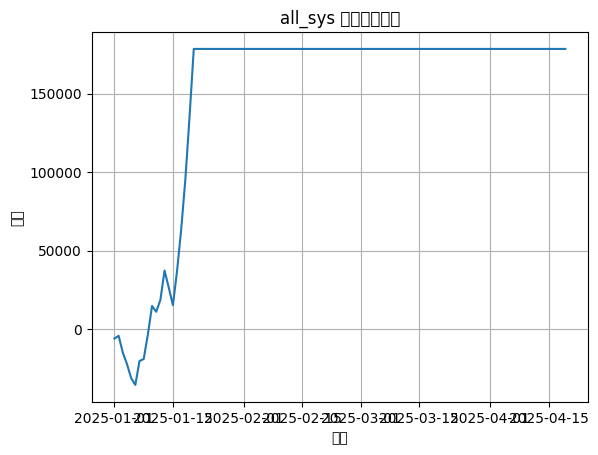

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 all_sys 数组已经定义
# all_sys = [1, 3, 2, 5, 4, 6, 5]
# 生成时间序列
dates = pd.date_range(start='2025-01-01', periods=len(total_sys))

# 绘制折线图
plt.plot(dates, total_sys)

# 添加标题和标签
plt.title('all_sys 数组数值变化')
plt.xlabel('日期')
plt.ylabel('数值')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [42]:
total_sys

[-5952.380952380953,
 -4227.357609710559,
 -14865.089374187672,
 -22201.846200257885,
 -31129.360958928977,
 -35496.628081650466,
 -20264.21696271984,
 -19028.895702128728,
 -3463.4611201301905,
 14783.293684573986,
 11091.54520757469,
 18588.728870226125,
 37360.26023638794,
 26581.982257506774,
 15283.823451231397,
 37179.09922559964,
 63914.61212440026,
 96016.75315934655,
 135884.22139914086,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,
 178499.9552636701,


In [43]:
max_return_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-02,2105,低吸,中位孕线低吸,600973.XSHG,宝胜股份,1,"000012.BKDL,000038.BKDL,000035.BKDL,000023.BKD...","885701.DDBK,885571.DDBK,885338.DDBK,886021.DDB...",980474.ZHBK,2,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,86.010,189.37,0.0,-7.94,5.80,5.90,-1.0,5.78,5.31,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-89.560000,-29.560000,141,-36.500000,-15.21,95,"{""9A0001"": {""realShortLineScore"": -43.86, ""rea...",2025-03-26 08:42:33,40642038.0,-0.003448,-0.004448,-0.084483,-0.085483,5.31,5.78,4.78,4.85,4.93,4.62,5.00,4.79,4.82,4.93,4.52,4.83,4.30,4.42,4.58,4.34,4.48,4.58,4.61,4.54,5.80,-0.084483,1.0
2025-01-08,2608,低吸,中位孕线低吸,603890.XSHG,春秋电子,1,"000038.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885338.DDBK,885840.DDBK,885467.DDBK,886064.DDB...",980357.ZHBK,1,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,52.330,160.53,0.0,-2.38,13.55,13.38,-1.0,13.16,12.74,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,21.220000,102.450000,21,3.480000,9.74,37,"{""9A0001"": {""realShortLineScore"": -53.33, ""rea...",2025-03-26 08:50:02,21815500.0,-0.028782,-0.029782,-0.059779,-0.060779,12.74,13.16,11.47,12.56,10.68,10.90,11.41,10.64,11.06,11.28,11.14,11.19,11.21,11.04,12.33,11.32,12.51,12.25,12.60,12.61,13.55,-0.073063,2.0
2025-01-13,2994,低吸,中位孕线低吸,003021.XSHE,兆威机电,2,"000012.BKDL,000038.BKDL,000014.BKDL,000006.BKD...","885338.DDBK,885785.DDBK,885517.DDBK,886046.DDB...",980474.ZHBK,1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,28.910,159.73,0.0,-1.63,90.50,85.99,-1.0,84.56,93.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-71.980000,-82.500000,116,-61.340000,-26.62,106,"{""9A0001"": {""realShortLineScore"": -29.91, ""rea...",2025-03-26 08:55:51,37994796.0,-0.065635,-0.066635,0.033481,0.032481,93.53,84.56,97.92,89.99,96.11,97.00,94.50,95.15,95.42,95.00,104.96,95.51,100.72,104.00,97.62,100.80,100.87,95.80,93.25,100.80,90.90,0.154675,6.0
2025-01-14,3155,低吸,中位孕线低吸,002577.XSHE,雷柏科技,1,"000012.BKDL,000038.BKDL,000026.BKDL,000014.BKD...","885338.DDBK,885517.DDBK,885774.DDBK,885603.DDB...",980366.ZHBK,1,1,30,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,30.630,164.43,0.0,-1.47,19.46,20.95,-1.0,21.00,20.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-80.150000,-8.170000,121,-62.950000,-22.06,108,"{""9A0001"": {""realShortLineScore"": -21.14, ""rea...",2025-03-26 08:57:57,11535888.0,0.079137,0.078137,0.054985,0.053985,20.53,21.00,20.05,20.53,20.22,19.87,19.95,20.54,21.32,19.94,20.79,20.91,19.96,21.02,20.28,19.62,18.80,20.20,19.32,19.21,19.52,0.065061,6.0
2025-01-22,4018,低吸,中位孕线低吸,605058.XSHG,澳弘电子,1,"000027.BKDL,000029.BKDL","886078.DDBK,885959.DDBK,885545.DDBK,885431.DDBK",980357.ZHBK,1,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,101.960,289.93,0.0,-4.96,23.00,24.45,-1.0,24.14,23.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.510000,2.630000,150,-79.730000,3.43,125,"{""9A0001"": {""realShortLineScore"": 7.15, ""realT...",2025-03-26 09:1

In [44]:
max_return_df.tail(15)['sy'].cumsum()

date_key
2025-01-02   -0.084483
2025-01-08   -0.157545
2025-01-13   -0.002870
2025-01-14    0.062191
2025-01-22    0.032716
2025-01-27    0.222029
2025-02-07    0.419477
2025-02-11    0.440365
2025-02-21    0.693213
2025-03-28    0.619798
2025-04-03    0.498868
2025-04-28    0.409246
2025-04-30    0.297454
2025-05-08    0.317062
2025-05-13    0.257538
Name: sy, dtype: float64

In [45]:
max_rate_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-02,2105,低吸,中位孕线低吸,600973.XSHG,宝胜股份,1,"000012.BKDL,000038.BKDL,000035.BKDL,000023.BKD...","885701.DDBK,885571.DDBK,885338.DDBK,886021.DDB...",980474.ZHBK,2,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,86.010,189.37,0.0,-7.94,5.80,5.90,-1.0,5.78,5.31,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-89.560000,-29.560000,141,-36.500000,-15.21,95,"{""9A0001"": {""realShortLineScore"": -43.86, ""rea...",2025-03-26 08:42:33,40642038.0,-0.003448,-0.004448,-0.084483,-0.085483,5.31,5.78,4.78,4.85,4.93,4.62,5.00,4.79,4.82,4.93,4.52,4.83,4.30,4.42,4.58,4.34,4.48,4.58,4.61,4.54,5.80,-0.168966,5.0
2025-01-08,2608,低吸,中位孕线低吸,603890.XSHG,春秋电子,1,"000038.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885338.DDBK,885840.DDBK,885467.DDBK,886064.DDB...",980357.ZHBK,1,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,52.330,160.53,0.0,-2.38,13.55,13.38,-1.0,13.16,12.74,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,21.220000,102.450000,21,3.480000,9.74,37,"{""9A0001"": {""realShortLineScore"": -53.33, ""rea...",2025-03-26 08:50:02,21815500.0,-0.028782,-0.029782,-0.059779,-0.060779,12.74,13.16,11.47,12.56,10.68,10.90,11.41,10.64,11.06,11.28,11.14,11.19,11.21,11.04,12.33,11.32,12.51,12.25,12.60,12.61,13.55,-0.183764,5.0
2025-01-13,2994,低吸,中位孕线低吸,003021.XSHE,兆威机电,2,"000012.BKDL,000038.BKDL,000014.BKDL,000006.BKD...","885338.DDBK,885785.DDBK,885517.DDBK,886046.DDB...",980474.ZHBK,1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,28.910,159.73,0.0,-1.63,90.50,85.99,-1.0,84.56,93.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-71.980000,-82.500000,116,-61.340000,-26.62,106,"{""9A0001"": {""realShortLineScore"": -29.91, ""rea...",2025-03-26 08:55:51,37994796.0,-0.065635,-0.066635,0.033481,0.032481,93.53,84.56,97.92,89.99,96.11,97.00,94.50,95.15,95.42,95.00,104.96,95.51,100.72,104.00,97.62,100.80,100.87,95.80,93.25,100.80,90.90,0.028933,1.0
2025-01-14,3155,低吸,中位孕线低吸,002577.XSHE,雷柏科技,1,"000012.BKDL,000038.BKDL,000026.BKDL,000014.BKD...","885338.DDBK,885517.DDBK,885774.DDBK,885603.DDB...",980366.ZHBK,1,1,30,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,30.630,164.43,0.0,-1.47,19.46,20.95,-1.0,21.00,20.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-80.150000,-8.170000,121,-62.950000,-22.06,108,"{""9A0001"": {""realShortLineScore"": -21.14, ""rea...",2025-03-26 08:57:57,11535888.0,0.079137,0.078137,0.054985,0.053985,20.53,21.00,20.05,20.53,20.22,19.87,19.95,20.54,21.32,19.94,20.79,20.91,19.96,21.02,20.28,19.62,18.80,20.20,19.32,19.21,19.52,0.075820,1.0
2025-01-22,4018,低吸,中位孕线低吸,605058.XSHG,澳弘电子,1,"000027.BKDL,000029.BKDL","886078.DDBK,885959.DDBK,885545.DDBK,885431.DDBK",980357.ZHBK,1,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,101.960,289.93,0.0,-4.96,23.00,24.45,-1.0,24.14,23.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.510000,2.630000,150,-79.730000,3.43,125,"{""9A0001"": {""realShortLineScore"": 7.15, ""realT...",2025-03-26 09:1

In [46]:
max_rate_df.tail(15)['sy'].cumsum()

date_key
2025-01-02   -0.168966
2025-01-08   -0.352729
2025-01-13   -0.323796
2025-01-14   -0.247977
2025-01-22   -0.201596
2025-01-27   -0.171062
2025-02-07    0.026387
2025-02-11    0.078606
2025-02-21    0.189084
2025-03-28    0.262498
2025-04-03    0.295057
2025-04-28    0.217226
2025-04-30    0.070213
2025-05-08    0.098870
2025-05-13    0.060775
Name: sy, dtype: float64

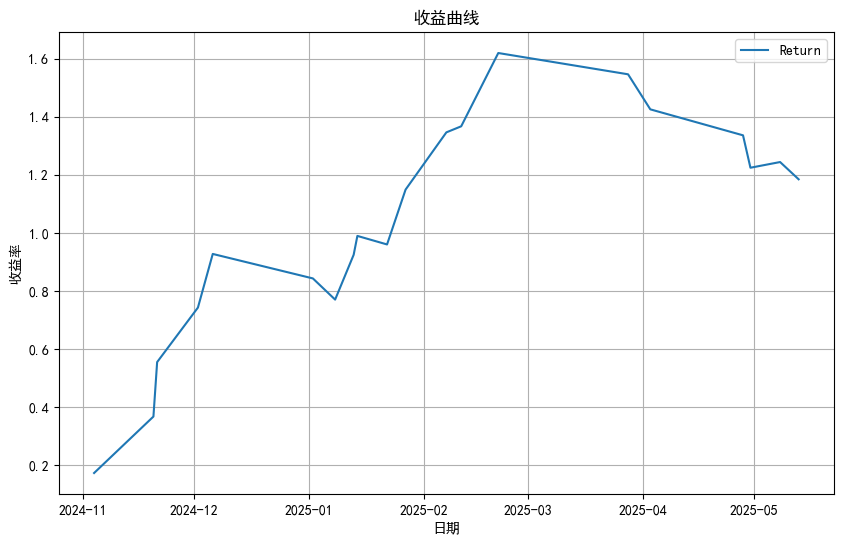

In [47]:
max_return_df['cumulative_returns'] = max_return_df['sy'].cumsum()
plot(max_return_df, 'cumulative_returns')

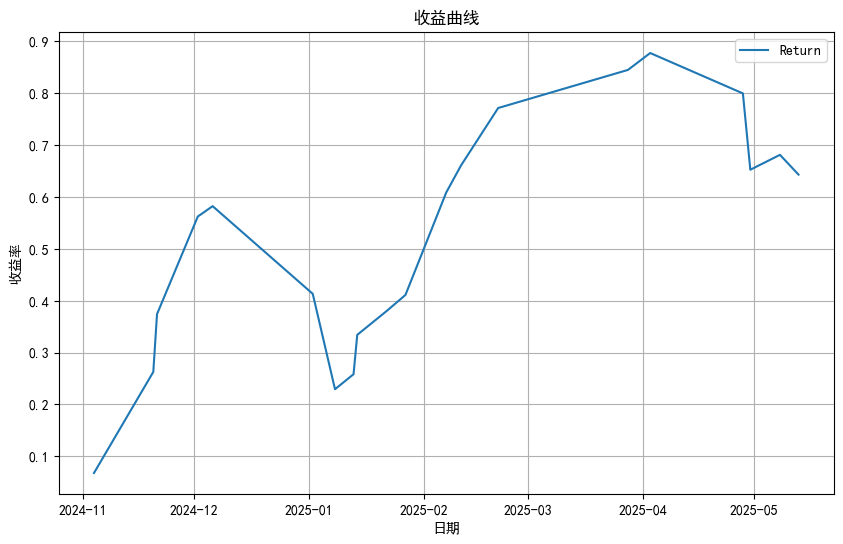

In [48]:
max_rate_df['cumulative_returns'] = max_rate_df['sy'].cumsum()
plot(max_rate_df, 'cumulative_returns')

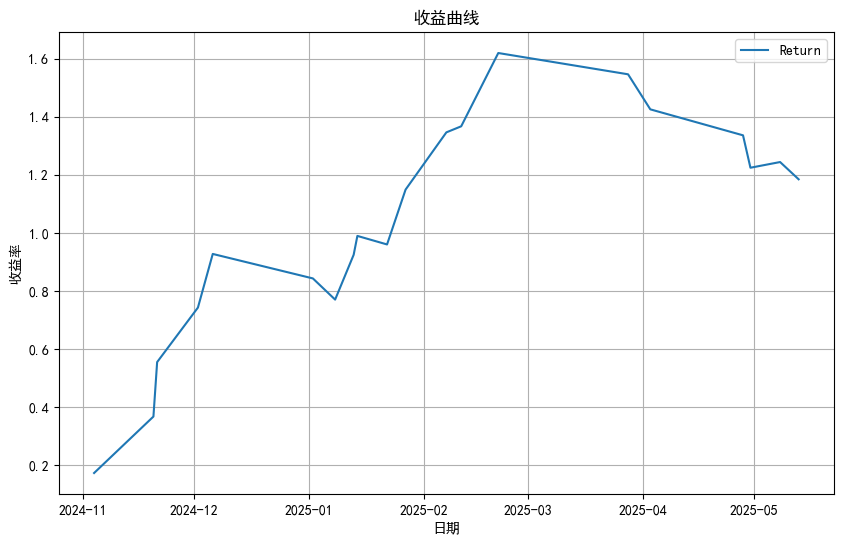

In [49]:
max_ykb_df['cumulative_returns'] = max_ykb_df['sy'].cumsum()
plot(max_ykb_df, 'cumulative_returns')

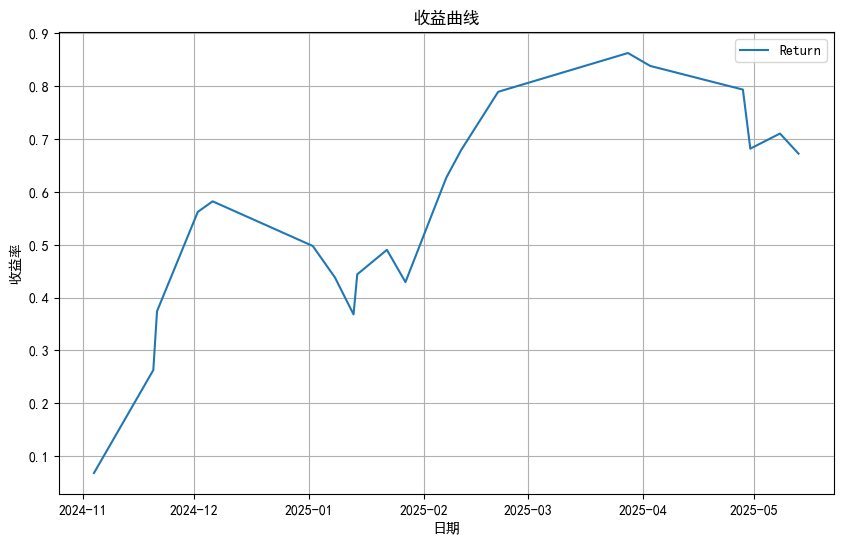

In [50]:
min_hc_df['cumulative_returns'] = min_hc_df['sy'].cumsum()
plot(min_hc_df, 'cumulative_returns')

In [51]:
max_ykb_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-02,2105,低吸,中位孕线低吸,600973.XSHG,宝胜股份,1,"000012.BKDL,000038.BKDL,000035.BKDL,000023.BKD...","885701.DDBK,885571.DDBK,885338.DDBK,886021.DDB...",980474.ZHBK,2,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,86.010,189.37,0.0,-7.94,5.80,5.90,-1.0,5.78,5.31,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-89.560000,-29.560000,141,-36.500000,-15.21,95,"{""9A0001"": {""realShortLineScore"": -43.86, ""rea...",2025-03-26 08:42:33,40642038.0,-0.003448,-0.004448,-0.084483,-0.085483,5.31,5.78,4.78,4.85,4.93,4.62,5.00,4.79,4.82,4.93,4.52,4.83,4.30,4.42,4.58,4.34,4.48,4.58,4.61,4.54,5.80,-0.084483,1.0,0.842981
2025-01-08,2608,低吸,中位孕线低吸,603890.XSHG,春秋电子,1,"000038.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885338.DDBK,885840.DDBK,885467.DDBK,886064.DDB...",980357.ZHBK,1,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,52.330,160.53,0.0,-2.38,13.55,13.38,-1.0,13.16,12.74,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,21.220000,102.450000,21,3.480000,9.74,37,"{""9A0001"": {""realShortLineScore"": -53.33, ""rea...",2025-03-26 08:50:02,21815500.0,-0.028782,-0.029782,-0.059779,-0.060779,12.74,13.16,11.47,12.56,10.68,10.90,11.41,10.64,11.06,11.28,11.14,11.19,11.21,11.04,12.33,11.32,12.51,12.25,12.60,12.61,13.55,-0.073063,2.0,0.769918
2025-01-13,2994,低吸,中位孕线低吸,003021.XSHE,兆威机电,2,"000012.BKDL,000038.BKDL,000014.BKDL,000006.BKD...","885338.DDBK,885785.DDBK,885517.DDBK,886046.DDB...",980474.ZHBK,1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,28.910,159.73,0.0,-1.63,90.50,85.99,-1.0,84.56,93.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-71.980000,-82.500000,116,-61.340000,-26.62,106,"{""9A0001"": {""realShortLineScore"": -29.91, ""rea...",2025-03-26 08:55:51,37994796.0,-0.065635,-0.066635,0.033481,0.032481,93.53,84.56,97.92,89.99,96.11,97.00,94.50,95.15,95.42,95.00,104.96,95.51,100.72,104.00,97.62,100.80,100.87,95.80,93.25,100.80,90.90,0.154675,6.0,0.924594
2025-01-14,3155,低吸,中位孕线低吸,002577.XSHE,雷柏科技,1,"000012.BKDL,000038.BKDL,000026.BKDL,000014.BKD...","885338.DDBK,885517.DDBK,885774.DDBK,885603.DDB...",980366.ZHBK,1,1,30,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,30.630,164.43,0.0,-1.47,19.46,20.95,-1.0,21.00,20.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-80.150000,-8.170000,121,-62.950000,-22.06,108,"{""9A0001"": {""realShortLineScore"": -21.14, ""rea...",2025-03-26 08:57:57,11535888.0,0.079137,0.078137,0.054985,0.053985,20.53,21.00,20.05,20.53,20.22,19.87,19.95,20.54,21.32,19.94,20.79,20.91,19.96,21.02,20.28,19.62,18.80,20.20,19.32,19.21,19.52,0.065061,6.0,0.989655
2025-01-22,4018,低吸,中位孕线低吸,605058.XSHG,澳弘电子,1,"000027.BKDL,000029.BKDL","886078.DDBK,885959.DDBK,885545.DDBK,885431.DDBK",980357.ZHBK,1,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,101.960,289.93,0.0,-4.96,23.00,24.45,-1.0,24.14,23.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.510000,2.630000,150,-79.730000,3.43,125,"{""9A0001"": {"

In [52]:
ddwndx['r_1return'] = ddwndx['close_1'] / ddwndx['real_open'] - 1
ddwndx['r_1return'] = ddwndx['r_1return']-0.001
ddwndx['cumulative_1returns'] = (1 + ddwndx['r_1return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_1return', _print=True, save_to_file=True)
print('-----------------------------------------------------')

return:
最大回撤: -24.14%
加和的最大回撤: -26.28%
夏普比率: 0.42
总收益率: 117.24%
年化收益率: 1406.93%
波动率: 10.48%
总盈亏: 100.18%
成功次数: 13
失败次数: 7
加和的收益: 88.92%
总天数: 20
总交易次数: 20
交易频率: 100.00%
胜率: 65.00%
平均盈利: 10.10%
平均亏损: -6.05%
最大盈利: 26.54%
最大亏损: -12.20%
盈亏比: 1.67
凯利公式最佳仓位: 44.02%
-----------------------------------------------------


In [53]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_1return,cumulative_1returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.170605,1.170605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.265421,1.481308
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.110272,1.644654
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.208524,1.987603
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realSho

In [54]:
ddwndx2 = ddwndx.copy()
ddwndx2 = ddwndx2[ddwndx2['close_2'] > 0]
ddwndx2['r_2return'] = ddwndx2['close_2'] / ddwndx2['real_open'] - 1
ddwndx2['r_2return'] = ddwndx2['r_2return']-0.001

ddwndx2['cumulative_2returns'] = (1 + ddwndx2['r_2return']).cumprod()
print("return:")
caculate_returns(ddwndx2, 'r_2return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -35.37%
加和的最大回撤: -41.30%
夏普比率: 0.29
总收益率: 78.53%
年化收益率: 942.32%
波动率: 13.05%
总盈亏: 61.10%
成功次数: 13
失败次数: 7
加和的收益: 74.62%
总天数: 20
总交易次数: 20
交易频率: 100.00%
胜率: 65.00%
平均盈利: 11.47%
平均亏损: -10.63%
最大盈利: 25.18%
最大亏损: -17.69%
盈亏比: 1.08
凯利公式最佳仓位: 32.54%
-----------------------------------------------------


In [55]:
def caculate_returns_n(returns_df, row, n=1000, _print=False):
    r = {}
    # 计算每天的收益金额
    daily_profit = n * returns_df[row]
    # 计算累计收益金额
    cumulative_profit = daily_profit.cumsum()

    # 计算最大回撤
    cumulative_max = cumulative_profit.cummax()
    drawdown = (cumulative_profit - cumulative_max)
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (daily_profit.mean() - risk_free_rate) / daily_profit.std()

    # 计算总收益率
    total_return = cumulative_profit.iloc[-1] / n

    # 计算波动率
    volatility = daily_profit.std()

    # 计算总盈亏
    total_profit_loss = cumulative_profit.iloc[-1]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = daily_profit[daily_profit > 0].count()
    losing_trades = daily_profit[daily_profit < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = daily_profit[daily_profit > 0].mean() if profitable_trades > 0 else 0
    average_loss = daily_profit[daily_profit < 0].mean() if losing_trades > 0 else 0
    max_profit = daily_profit.max()
    max_loss = daily_profit.min()
    total_trades = profitable_trades + losing_trades
    total_times = daily_profit.count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] = max_drawdown / n
    r['夏普比率'] = sharpe_ratio
    r['总收益率'] = total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown / n:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2f}")
        print(f"总盈亏: {total_profit_loss:.2f}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2f}")
        print(f"平均亏损: {average_loss:.2f}")
        print(f"最大盈利: {max_profit:.2f}")
        print(f"最大亏损: {max_loss:.2f}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [56]:
i=3
ddwndx_i = ddwndx.copy()
# 筛选出 close_i 大于 0 的数据
ddwndx_i = ddwndx_i[ddwndx_i[f'close_{i}'] > 0]
# 计算 r_ireturn
ddwndx_i[f'r_{i}return'] = ddwndx_i[f'close_{i}'] / ddwndx_i['real_open'] - 1
# 扣除手续费
ddwndx_i[f'r_{i}return'] = ddwndx_i[f'r_{i}return'] - 0.001

print(len(ddwndx_i[ddwndx_i[f'r_{i}return'] > 0]))
# 计算累计收益
ddwndx_i[f'cumulative_{i}returns'] = (1 + ddwndx_i[f'r_{i}return']).cumprod()
print(f"return_{i}:")
caculate_returns_n(ddwndx_i, f'r_{i}return', _print=True)
print('-----------------------------------------------------')

12
return_3:
最大回撤: -38.81%
夏普比率: 0.21
总收益率: 52.19%
年化收益率: 626.23%
波动率: 123.90
总盈亏: 521.86
成功次数: 12
失败次数: 8
总天数: 20
总交易次数: 20
交易频率: 100.00%
胜率: 60.00%
平均盈利: 111.29
平均亏损: -101.70
最大盈利: 242.74
最大亏损: -212.81
盈亏比: 1.09
凯利公式最佳仓位: 23.45%
-----------------------------------------------------


In [57]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -24.14%
加和的最大回撤: -26.28%
夏普比率: 0.42
总收益率: 117.24%
年化收益率: 1406.93%
波动率: 10.48%
总盈亏: 100.18%
成功次数: 13
失败次数: 7
加和的收益: 88.92%
总天数: 20
总交易次数: 20
交易频率: 100.00%
胜率: 65.00%
平均盈利: 10.10%
平均亏损: -6.05%
最大盈利: 26.54%
最大亏损: -12.20%
盈亏比: 1.67
凯利公式最佳仓位: 44.02%
-----------------------------------------------------


In [58]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_1return,cumulative_1returns,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.170605,1.170605,0.170605,1.170605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.265421,1.481308,0.265421,1.481308
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.110272,1.644654,0.110272,1.644654
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.208524,1.987603,0.208524,1.987603
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1

In [59]:
len(ddwndx)

20

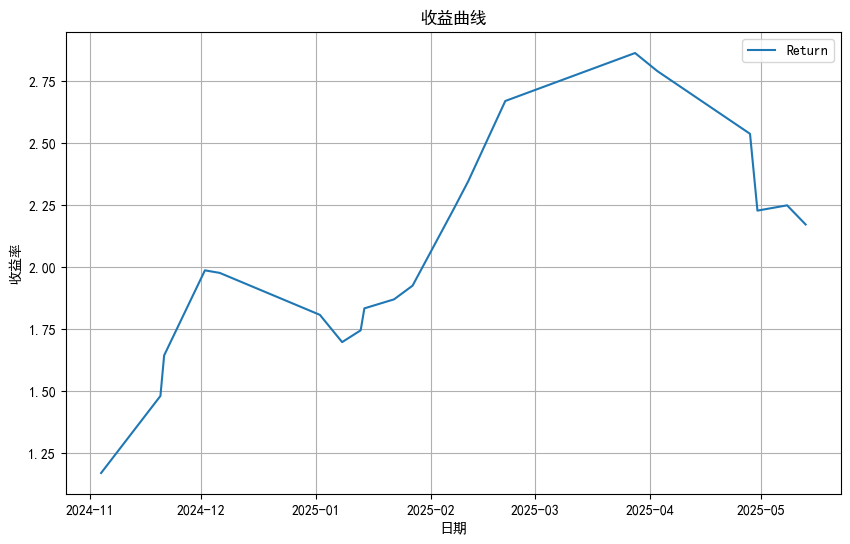

In [60]:
plot(ddwndx, 'cumulative_returns')

In [61]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

In [62]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_1return,cumulative_1returns,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.208524,1.987603,0.208524,1.987603,1.016949
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-03-26 08:01:50,50939592.0,0.029724,0.028724,0.005308,0.004308,9.47,9.70,10.42,9.76,10.81,10.57,11.27,10.65,11.84,10.88,11.76,12.18,10.58,11.38,10.25,10.03,9.76,10.01,9.79,9.80,9.51,-0.005206,1.977256,-0.005206,1.977256,1.009554
2025-04-03,1072,低吸,中位孕线低吸,600610.XSHG,中毅达,1,"000038.BKDL,000024.BKDL,000023.BKDL,000019.BKD...","885520.DDBK,885338.DDBK,883436.DDBK,886021.DDB...","980338.ZHBK,980364.ZHBK",1,1,10,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,28.830,193.54,0.0,-1.84,8.52,9.32,-1.0,8.39,8.39,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-67.630000,-146.300000,107,74.830000,-20.27,6,"{""9A0001"": {""realShortLineScore"": -40.17, ""rea...",2025-04-07 08:00:41,24789792.0,-0.015258,-0.016258,-0.015258,-0.016258,8.39,8.39,7.56,8.59,7.50,6.95,8.25,7.60,8.88,8.20,9.77,9.17,10.75,10.10,11.20,10.80,11.18,11.09,11.25,10.60,8.60,-0.025419,2.790878,-0.025419,2.790878,1.009390
2025-02-07,4190,低吸,中位孕线低吸,003005.XSHE,竞业达,2,"000012.BKDL,000003.BKDL,000038.BKDL,000008.BKD...","886100.DDBK,885514.DDBK,886062.DDBK,885586.DDB...","980753.ZHBK,980366.ZHBK",1,1,6,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0.0,134.930,211.45,0.0,-7.00,34.29,40.56,-1.0,41.30,40.01,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-97.490000,-11.260000,169,-89.710000,-6.62,154,"{""9A0001"": {""realShortLineScore"": 49.57, ""real...",2025-03-26 09:24:33,18171642.0,0.204433,0.203433,0.166812,0.165812,40.01,41.30,38.02,38.52,39.04,37.50,39.29,38.25,40.99,38.43,41.79,41.00,37.78,40.67,41.56,37.26,40.08,41.90,40.71,40.14,34.49,0.159046,2.232250,0.159046,2.232250,1.005833
2025-04-28,7551,低吸,中位孕线低吸,600969.XSHG,郴电国际,1,"000008.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","883436.DDBK,885936.DDBK,885692.DDBK,886021.DDB...",,1,1,-1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,40.236,19

<Axes: ylabel='Frequency'>

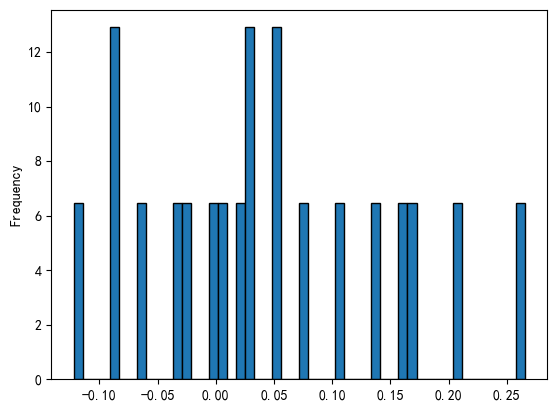

In [63]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [64]:

t63 = max_ykb_df.tail(100)
t63['cumulative_returns'] = (1 + t63['sy']).cumprod()
print("return:")
caculate_returns(t63, 'sy', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -36.84%
加和的最大回撤: -43.57%
夏普比率: 0.45
总收益率: 172.81%
年化收益率: 2073.74%
波动率: 13.12%
总盈亏: 155.65%
成功次数: 12
失败次数: 8
加和的收益: 118.50%
总天数: 20
总交易次数: 20
交易频率: 100.00%
胜率: 60.00%
平均盈利: 15.23%
平均亏损: -8.03%
最大盈利: 25.28%
最大亏损: -12.09%
盈亏比: 1.90
凯利公式最佳仓位: 38.91%
-----------------------------------------------------


In [65]:
max_ykb_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.171605,1.0,0.171605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.194834,1.0,0.366439
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.187861,2.0,0.554300
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.188095,1.0,0.742395
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A

In [66]:
t63

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.171605,1.0,1.171605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.194834,1.0,1.399873
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.187861,2.0,1.662855
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.188095,1.0,1.975631
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A

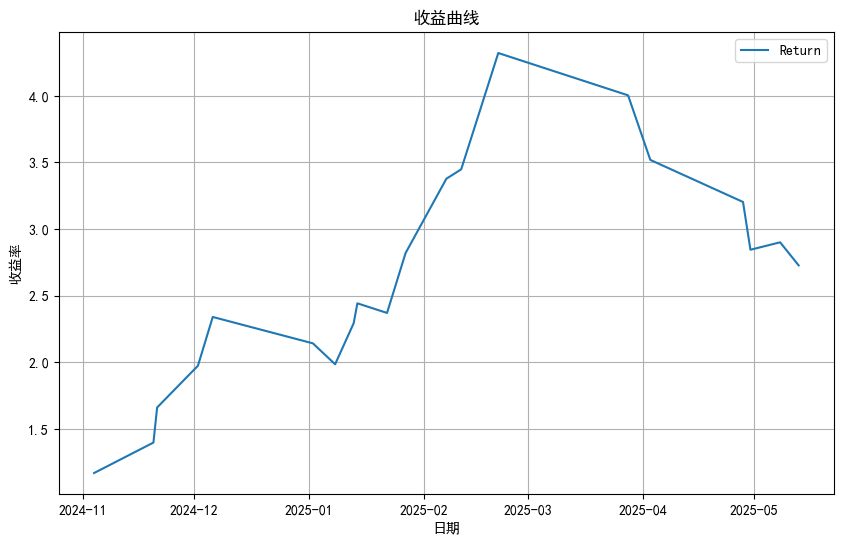

In [67]:
plot(t63.tail(60), "cumulative_returns")

In [68]:
t63.head(10)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.14,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.70,-121.66,121,53.39,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.171605,1.0,1.171605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.42,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.55,10.89,163,-47.47,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.194834,1.0,1.399873
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.26,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.27,47.28,152,-23.33,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.187861,2.0,1.662855
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.43,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.46,80.39,59,15.41,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.188095,1.0,1.975631
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.38,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.35,12.10,12,90.67,12.84,21,"{""9A0001"": {""realShortLineScore"": 48.34, ""real...",2025-03-26 08:

In [69]:
max_ykb_df.tail(50)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,3313,低吸,中位孕线低吸,600212.XSHG,绿能慧充,1,"000038.BKDL,000023.BKDL,000035.BKDL,000019.BKD...","885338.DDBK,883436.DDBK,886089.DDBK,885921.DDB...","980474.ZHBK,980352.ZHBK",1,1,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,38.140,156.88,0.0,-4.82,8.10,8.63,-1.0,8.65,9.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-22.700000,-121.660000,121,53.390000,-34.11,58,"{""9B0003"": {""realShortLineScore"": -0.5, ""realT...",2025-03-26 07:04:22,11337570.0,0.067901,0.066901,0.171605,0.170605,9.49,8.65,9.52,9.96,9.58,9.41,9.79,9.50,9.48,9.61,9.12,9.48,9.87,9.12,9.18,10.00,8.78,8.81,8.58,8.79,8.10,0.171605,1.0,0.171605
2024-11-20,5493,低吸,中位孕线低吸,002553.XSHE,南方精工,2,"000014.BKDL,000023.BKDL,000010.BKDL,000027.BKD...","885771.DDBK,885517.DDBK,885929.DDBK,885675.DDB...",980372.ZHBK,1,1,16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,160.420,227.75,0.0,-4.80,13.50,15.60,-1.0,16.19,17.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-88.550000,10.890000,163,-47.470000,10.78,151,"{""9A0001"": {""realShortLineScore"": 2.3600001, ""...",2025-03-26 07:33:20,26829900.0,0.199259,0.198259,0.271111,0.270111,17.16,16.19,16.50,17.20,14.98,15.50,13.48,14.50,13.33,13.01,13.32,13.47,13.51,13.07,13.92,13.58,14.00,13.93,15.40,14.00,13.55,0.194834,1.0,0.366439
2024-11-21,5653,低吸,中位孕线低吸,600228.XSHG,返利科技,3,"000012.BKDL,000003.BKDL,000023.BKDL,000010.BKD...","885520.DDBK,883436.DDBK,885420.DDBK,885788.DDB...","980753.ZHBK,980355.ZHBK,980364.ZHBK",2,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,6,0.0,53.260,154.65,0.0,-3.50,6.90,6.99,-1.0,6.77,7.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-41.270000,47.280000,152,-23.330000,-7.49,142,"{""9A0001"": {""realShortLineScore"": 29.53, ""real...",2025-03-26 07:35:33,11138670.0,-0.018841,-0.019841,0.114493,0.113493,7.69,6.77,8.46,8.22,7.66,8.96,7.18,7.30,7.11,7.19,7.10,7.01,7.42,7.14,7.31,7.31,6.96,7.26,7.18,7.00,6.92,0.187861,2.0,0.554300
2024-12-02,3131,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000023.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","886086.DDBK,883437.DDBK,885783.DDBK,885770.DDB...","980365.ZHBK,980355.ZHBK",1,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.430,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.460000,80.390000,59,15.410000,2.55,101,"{""9A0001"": {""realShortLineScore"": 46.28, ""real...",2025-03-26 07:51:45,31189760.0,0.208232,0.207232,0.230024,0.229024,5.08,4.99,4.88,5.59,4.53,4.75,4.98,4.56,5.48,5.33,6.03,6.03,6.63,5.60,7.29,6.77,8.02,7.40,7.22,8.30,4.20,0.188095,1.0,0.742395
2024-12-06,3953,低吸,中位孕线低吸,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885933.DDBK,885867.DDBK,885517.DDBK,886062.DDB...",980355.ZHBK,1,1,18,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,84.380,178.67,0.0,-1.87,9.42,9.70,-1.0,9.70,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,94.350000,12.100000,12,90.670000,12.84,21,"{""9A

In [70]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%


: 